## Pretraining On Unlabeled Data ##

BAB 5  
1. Menghitung training dan validation loss untuk menilai kualitas LLM-generated text saat pelatihan  
2. Implementasi training-function dan pretraining LLM  
3. Menyimpan dan load model weights untuk melanjutkan pelatihan LLM  
4. Load pretraining weights dari OpenAi

### 5.1 Evaluating generative text models

#### 5.1.1 Using GPT to generate text

In [1]:
import torch
import torch.nn as nn
from GPTModel import GPTModel, GPT_CONFIG_124M

*Lihat `GPTModel.py`  
Context length dirubah menjadi 256

In [2]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformersBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformersBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_featur

1. Menggunakan tokenizer untuk encode input teks menjadi representasi token ID  
2. Ketika diberikan token ID, model akan memproduksi n logits vectors (baris), dimana setiap vektor memiliki 50,257 elemen (kolom) == vocabulay_size  
3. Setelah convert logits menjadi token ID, kita menggunakan tokenizer untuk decode token ID kembali representasi teks

In [3]:
import tiktoken
from GenerateText import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [4]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding('gpt2')


In [5]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']
)

print("Output text : \n", token_ids_to_text(token_ids, tokenizer))

Output text : 
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


#### 5.1.2 Calculating the text generation loss

Secara graph proses prediksi token atau kata berikutnya seperti ini :  
1. Setiap kata dirubah menjadi token id berdasar indeks didalam vocabulary  
2. Token id ini akan diproses oleh model sehingga menghasilkan vector berdimensi tinggi yang berbentuk probabilitas (setelah fungsi softmax, ketika diijumlahkan akan menjadi satu)  
3. Kemudian mencari `argmax` dari setiap baris vektor, dan melihat indeks posisinya  
4. Indeks dengan nilai tertinggi inilah yang menjadi tebakan atau prediksi kata selanjutnya  
4. Kemudian (indeks )token ids dengan nilai tertinggi ini di konversi kembali menjadi kata sesuai dengan indeks dalam vocabulary

In [6]:
inputs = torch.tensor([[16833, 3626, 6100],     # ' every effort moves
                       [40, 1107, 588]])        # 'i really like'

In [7]:
targets = torch.tensor([[3626, 6100, 345],      # 'effort moves you'
                        [1107, 588, 11311]])    # "really like chocholate"

Kemudian kita memasukann inputs diatas ke model untuk mengkalkulasi logist vectors, setelahnya melakukan fungsi softmax

In [8]:
with torch.no_grad(): # disable gradient tracking
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)

print(probas.shape)

torch.Size([2, 3, 50257])


2 >> dua inputs  
3 >> banyak token atau kata  
50257 >> embedding dimensionality

In [9]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs : \n", token_ids)

Token IDs : 
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [10]:
print(f"Targets batch 1 : {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1 : {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1 :  effort moves you
Outputs batch 1 :  Armed heNetflix


Pada saat melatih model, tujuannya adalah untuk **memaksimisasi/memaksimalkan** nilai pada indeks yang sesuai dengan **target**  


In [11]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]

print("Text 1 : ", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]

print("Text 2 : ", target_probas_2)

Text 1 :  tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2 :  tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


Bagaimana kita memaksimalkan softmax probability yang merupakan target token?  
Caranya adalah memperbarui model weights. Sehingga, output dari model adalah nilai tertinggi yang merupakan token ids yang ingin kita generate (sesuai dengan target sebenarnya). Proses ini disebut **backpropagation**  
**Backpropagation** sendiri membutuhkan *loss function*, yaitu menghitung selisih antara prediksi dari model dengan nilai sebenarnya.

In [12]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [13]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


Goals kita adalah mendapatkan nilai rata-rat log probabilitas mendekati 0, dengan cara update model weights yang merupakan bagian dari pelatihan. Pada konteks deep learning praktik umum yang sering dilakukan bukanlah mendorong rata-rata log probabilites menuju 0, tapi menurunkan negative avg log probability mendekati 0.

In [14]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


Pada konteks deep learning, mengubah negative values ini disebut dengan *cross entropy loss*

In [15]:
# before we appluy the cross_entrpy funtion, lets briefly recall the shape of the logist
print('logits shape : ', logits.shape)
print('Targets shape : ', targets.shape)

logits shape :  torch.Size([2, 3, 50257])
Targets shape :  torch.Size([2, 3])


Dapat dilihat. Logits tensor memiliki tiga dimensi (batch_size, number of tokens, dan vocabulary size). Sedangkan target memiliki dua dimensi (batch_size, number of tokens)

In [16]:
# before apply cross_entropy, we flatten the logits and targets tensors
logits_flat = logits.flatten(0, 1) # (batch_size * context_length, vocab_size)
targets_flat = targets.flatten()

print('logits_flat shape : ', logits_flat.shape)
print('targets_flat shape : ', targets_flat.shape)

logits_flat shape :  torch.Size([6, 50257])
targets_flat shape :  torch.Size([6])


PyTorch cross_entropy akan menghandle step-step yang telah kita lakukan sebelumnya (softmax + calculate log)

In [17]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


Hasilnya sama dengan apa yang telah kita lakuakan sebelumnya

#### 5.1.3 Calculating the training and validation set loss

Untuk menghitung loss pada saat training dan validasi kita akan menggunakan dataset 'The Verdict'

In [18]:
# loads data
file_path = 'the-verdict.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [19]:
# check the numer of characters in dataset
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print('Total characters : ', total_characters)
print('Total tokens : ', total_tokens)

Total characters :  20479
Total tokens :  5145


Hany dengan 5145 tokens, teks akan terasa ringan karena kita hanya inginn melatih model dalam hitungan menit saja alih-alih berminggu-minggu seperti model-model LLM besar lainnya

Selanjutnya kita akan membagi dataset menjadi training dan validation menggunakan data loader yang sudah dipelajari di chapter 2. Karena kendala spasial, kita akan menggunakan `max_length = 6`. Bagaimanapun, secara aktual pada data loaders, kita menggunakan `max_length = 256` agar LLM bisa melihat konteks yang lebih panjang pada saat training.

In [20]:
# split data into training and validation 
train_ratio = 0.90
split_dx = int(train_ratio * len(text_data))
train_data = text_data[:split_dx]
val_data = text_data[split_dx:] 

In [21]:
from DataLoaderV1 import create_data_loader_v1

torch.manual_seed(123)

train_loader = create_data_loader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_data_loader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [22]:
# check
print('Train loader : ')
for x, y in train_loader:
    print(x.shape, y.shape)


print('\nValidation loader : ')
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader : 
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader : 
torch.Size([2, 256]) torch.Size([2, 256])


Dari output terlihat bahwa kita memiliki 9 set data training, dan satu set data untuk validasi. Setiap set terdiri dari 2 batch (teks), dan 256 token (kata). 

Selanjutnya kita membuat fungsi untuk menghitung cross entropy loss

In [23]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    # memindahkan input ke GPU
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1),
                                             target_batch.flatten())
    return loss

In [24]:
# function to compute the training and validation loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
        # menyampatkan jumlah batch dengan data loader
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, 
                target_batch,
                model,
                device
            )
            total_loss += loss.item() # sums of loss for each batch
        else:
            break
    
    return total_loss / num_batches

Secara default, `calc_loss_loader` melakukan iterasi di semua batches pada data loader yang diberikan. Mengakumulasi nilai loss di `total_loss`, dan menghitung rata-ratanya. Alternatif, kita bisa menspesifikasi angka bathces yang lebih kecil via `num_bathces` untuk mempercepat proses evaluasi selama training model. 

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) # set to the GPU

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print('Train loss : ', train_loss)
print('Validation loss :', val_loss)

Train loss :  10.987583372328016
Validation loss : 10.981104850769043


### 5.2 Training an LLM

Tips untuk melatih model LLM adalah menggunakan loop, yang berguna agar code tetap konsisten dan mudah dibaca

Secara umum ada 8 langkah. Dimulai dari iterasi dari setiap epoch, memproses batch, mereset gradient, menghitung loss dan gradient baru, update bobot.

In [26]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq
                       ,eval_iter, start_context, tokenizer):
    # initialize list to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # start the main training loop
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            # reset loss gradients from the previous batch iteration
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # calculate loss gradient
            loss.backward()
            # update model weights using loss gradients
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            # optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Ep {epoch+1} (Step {global_step:06d}) : "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                      )
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

- token seen : jumlah total token unik atau token yang telah dipaparkan (dilihat) oleh model LLM selama proses pelatihannya  
- global step : singkatnya, global step adalah hitungan kumulatif dari batch yang telah diproses, sementara epoch adalah hitungan berapa kali seluruh dataset telah dilewati. Global step memberikan pandangan yang lebih detail tentang kemajuan pelatihan secara keseluruhan.

In [27]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # set model to evaluation mode
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train() # set model back to training mode

    return train_loss, val_loss

In [28]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval() # set model to evaluation mode
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        output = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(output, tokenizer)

    print(decoded_text.replace("\n", " "))
    model.train() # set model back to training mode

Hampir sama dengan `evaluate_model`, fungsi `generate_and_print_sample` digunakan untuk tracking apakah performa model meningkat selama proses pelatihan. Fungsi `generate_and_print_sample` menerima `start_context` sebagai input, mengubahnya menjadi token ids, dan memasukkannya kedalam model LLM untuk membuat sample text menggunakan fungsi `generate_and_print_sample`.

In [29]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(), # returns all trainable partameters of the model 
    lr = 0.0004,
    weight_decay=0.1
)


AdamW adalah varian dari adam yang meningkatkan weight_decay yang bertujuan untuk kompleksitas dari model dan menghindari overfitting dengan memberikan penalti untuk bobot yang besar.

In [30]:
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000) : Train loss 9.821, Val loss 9.931
Ep 1 (Step 000005) : Train loss 8.069, Val loss 8.334
Every effort moves you,,,,,,,,,,,,,,.                                   
Ep 2 (Step 000010) : Train loss 6.623, Val loss 7.049
Ep 2 (Step 000015) : Train loss 6.046, Val loss 6.598
Every effort moves you, and,, and,,,,,,,,,.                                   
Ep 3 (Step 000020) : Train loss 5.558, Val loss 6.503
Ep 3 (Step 000025) : Train loss 5.471, Val loss 6.392
Every effort moves you, and to the to the of the to the, and I had. Gis, and I had, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030) : Train loss 4.995, Val loss 6.275
Ep 4 (Step 000035) : Train loss 4.756, Val loss 6.289
Every effort moves you, and I had been the picture.                    "I"I the the donkey of the donkey the donkey of the picture and I had been a"I
Ep 5 (Step 000040) : Train loss 4.113, Val loss 6.182
Every effort moves you know the "Oh, and he had to me--I 

Agar mudah melihat performa dari model pada saat pelatihan, mari lakukan visualisasi plot

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(epochs_seen, train_losses, label='Training Loss')
    ax1.plot(epochs_seen, val_losses, linestyle='-.', label='Validatio Loss')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel('Token seen')

    fig.tight_layout()
    plt.show()

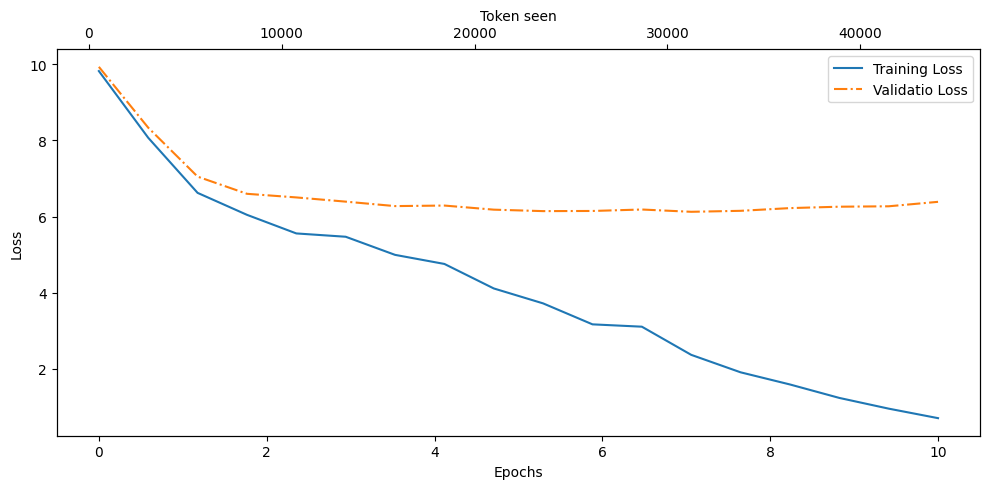

In [32]:
epoch_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epoch_tensor, tokens_seen, train_losses, val_losses)

Training plot pelatihan dan validasi yang dihasilkan, seperti yang dapat kita lihat, kerugian pelatihan dan validasi mulai membaik pada epoch pertama. Namun, kerugian mulai menyimpang setelah epoch kedua. Divergensi ini dan fakta bahwa kerugian validasi jauh lebih besar daripada kerugian pelatihan menunjukkan bahwa model tersebut overfitting dengan data pelatihan. Kita dapat memastikan bahwa model tersebut mengingat data pelatihan kata demi kata dengan mencari potongan teks yang dihasilkan, seperti ironi yang tidak masuk akal dalam berkas teks "The Verdict".

Overfitting ini terinndikasi karena kita melatih model dengan dataset yang kecil dan melatihnya dengan beberapa epoch. Pada umumnya model dilatih pada dataset yang cukup masif untuk satu epoch saja. 

### 5.3 Decoding strategies to control randomness

Generation strategies atau disebut decoding strategies yang digunakan untuk menggenerasi teks-teks original. Ada dua teknik untuk meningkatkan dalam generasi teks yaitu **temperature scaling** dan **top-k sampling**.  
Kita mulai dengan merubah device kembali ke CPU, karen inferensi tidak terlalu membutuhkan sumber daya yang tinggi.

In [33]:
model.to('cpu')
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformersBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformersBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_featur

Selanjutnya kita memasangkan `GPTModel` pada `generate_text_sample` untuk menggenerasi token dalam satu waktu

In [34]:
tokenizer = tiktoken.get_encoding('gpt2')
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']
)

print("Output text : \n", token_ids_to_text(token_ids, tokenizer))

Output text : 
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




Dari output yang diberikan teks yang dihasilkan pada proses generasi teks sesuai dengan teks yang memiliki probabilitas tertinggi diantara semua token di vocab. Ini artinya setiap kali kita run LLM akan menghasilkan hasil yang sama

#### 5.3.1 Temperature Scaling

Temperature scaling adalah teknik yang menambahkan pengaturan distribusi probabilitas pada next-token generation. Sebelumnya pada `generate_text_simple`, kita selalu melakukan pemilihan token setelahnya menggunakan probabilitas yang tertinggi via `torch.argmax` yang bisa disebut *greedy dicoding*. Untuk hasil generasi yang lebih bervariasi, kita dapat mengganti `argmax` dengan fungsi sampling probabilitas.

In [35]:
vocab = {
    'closer' : 0,
    'every' : 1,
    'effort' : 2,
    'forward' : 3,
    'inches' : 4,
    'moves' : 5,
    'pizza' : 6,
    'toward' : 7,
    'you' : 8,
}

# invers vocab, sehingga menghasilkan pasangan key-value (dibalik)
inverse_vocab = {v: k for k, v in vocab.items()}

In [36]:
# assume LLM has next-token logits for 'every effort moves you'
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [37]:
# convert logits to probabilities via softmax
# obtain ID via argmax

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item() # mengembalikan index
print(inverse_vocab[next_token_id])

forward


Untuk mengimplementasikan proses sampling probabilistik, kita dapat menggantikan `argmax` dengan `multinomial`

In [38]:
torch.manual_seed(123)

next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [39]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item()
              for _ in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


Dapat dilihat, kata-kata lain muncul cukup banyak. Jika kita menerapkan ini pada proses generasi teks di LLM maka hasil next-token yang diberikan bisa variatif.

Lebih jauh kita bisa mengontrol pengaturan dari distribusi via **temperature scaling**. Ini adalah istilah lain dari membagi logits dengan angka yang lebih dari 0

In [40]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

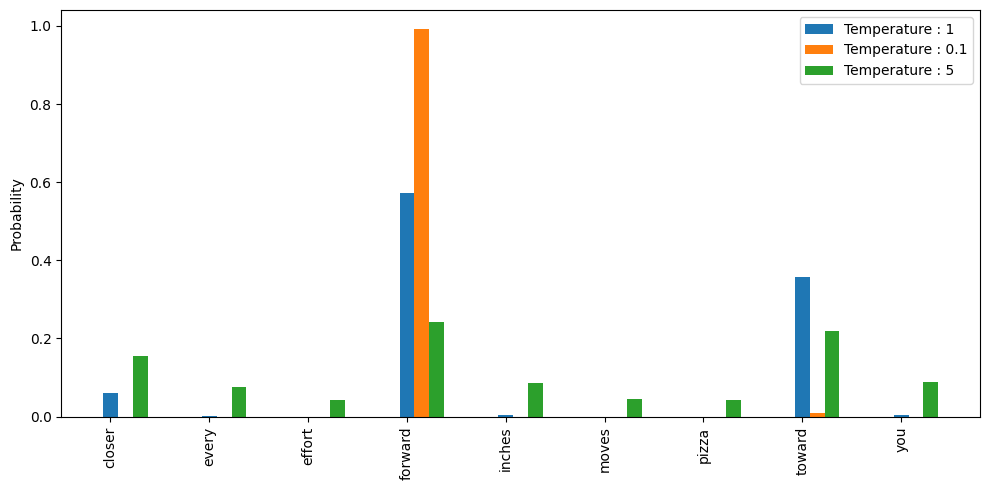

In [41]:
temperatures = [1, 0.1, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, T)
                 for T in temperatures]

x = torch.arange(len(vocab))

bar_width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))
for i,  T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f"Temperature : {T}")

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation = 90)
ax.legend()
plt.tight_layout()
plt.show()

**Efek temperature**  
- Temperature > 1  
Membuat distribusi probabilitas lebih seragam (mendekati distribusi uniform). Model akan menghasilkan prediksi yang cenderung acak dan variatif  
- Temperature < 1  
Membuat distribusi probabilitas lebih tajam, sehingga token dengan probabilitas tertinggi lebih dominan. Model menghasilkan output yang lebih deterministik, dan paling mungkin sesuai konteks  
- Temperature 1  
Distribusi probabilitas tetap seperti aslinya  
- Temperature 0  
Secara efektif memilih token dengan probabilitas tertinggi (greedy decoding). Output sangat deterministik

#### 5.3.2 Top-k sampling

Pada top-k sampling kita dapat membatasi token yang disampling untuk menjadi top-k token dan tidak menghiraukan token yang tidak termasuk dengan melakukan masking pada probability scoresnya.

Untuk token-token yang tidak termasuk dalam top-k tokens dapat dimasking menggunakan negative infinity (-inf)

In [42]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits : ", top_logits)
print("Top positions : ", top_pos)

Top logits :  tensor([6.7500, 6.2800, 4.5100])
Top positions :  tensor([3, 7, 0])


Dengan fungsi `where` pada PyTorch kita bisa menerapkan top-k

In [43]:
new_logits = torch.where(
    condition=
    next_token_logits < top_logits[-1], # mengambil kondisi dimana nilai yang kurang dari top_k
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [44]:
# apply softmax funcrtion to new_logits
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Sekarang kita dapat menerapkan temperature scaling dan multinomial function untuk sampling probabilitas untuk memilih token selanjutnya diantara 3 probabilitas tertinggi (top-k). Kita melakukan ini dengan memodifikasi fungsi generasi teks

#### 5.3.3 Modifying the text generation function

In [45]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # top_k sampling
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')),
                logits
            )
        
        # temperature scaling
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        
        # greedy sampling
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        # stop if end of seq token is reached
        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [46]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M['context_length'],
    top_k=5,
    temperature=1.4
)

print('Output text : \n', token_ids_to_text(token_ids, tokenizer))

Output text : 
 Every effort moves you know began to my surprise, one of the face the irony. She wanted


### 5.4 Loading and saving model weights in PyTorch

In [47]:
torch.save(model.state_dict(), 'model.pth')

Kemudian kita dapat memuat bobot model ke GPTModel yang baru

In [48]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load('model.pth', map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformersBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformersBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_featur

Seperti yang didiskusikan di Chapter 4, dropout membantu model untuk menghindari overfitting pada pelatihan dengan cara mematikan beberapa layer saat pelatihan. Pada saat inferensi (prediksi) kita tidak ingin secara acak mematikan informasi yang telah dipelajari oleh model.  
Dengan `model.eval()` akan mengubah model menjadi mode evaluasi, mematikan dropout layer. Jika kita ada rencana untuk melanjutkan pretraining di kemudian waktu, menyimpan state dari optimizer direkomendasikan.

Optimizer adaptive seperti AdamW menyimpan tambahan parameter untuk setiap bobot model. AdamW menggunakan histori dari data untuk menyesuaikan learning rate untuk setiap parameter model secara dinamis. Tanpa ini, optimizer akan ter-reset dan model akan sulit untuk konvergen dapat menyebabkan kegagalan.  
Dengan `torch.save` kita dapat menyimpan model dan juga parameter `state_dict`

In [49]:
torch.save({
    "model_state_dict" : model.state_dict(),
    "optimizer_state_dict" : optimizer.state_dict()},
    "model_and_optimizer.pth"
    )

In [50]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformersBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformersBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_featur

### 5.5 Loading pretrained weights from OpenAI

In [51]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py"
)

filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x2895b1dce50>)

Selesai mendownload dan tersimpan di lokal kita, setelahnya kita harus melakukan pengecekan untuk memastikan ini disimpan secara benar dan mengandung kode python yang valid.  

In [52]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size='124M',
    models_dir='gpt2'
)

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json


model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [10:31<00:00, 789kiB/s]  


File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [53]:
print("Settings : ", settings)
print("Parameter dictionary key : ", params.keys())

Settings :  {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary key :  dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


- `settings` berisi tentang konfigurasi dari arsitektur LLM  
- `params` berisi tentang bobot tensor aktual

In [55]:
# melihat beberapa bobot parameter
print(params['wte'])
print('Token embedding weight tensor dimension :', params['wte'].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimension : (50257, 768)


Setelah kita berhasil mme-load model dari GPT OpenAI kita harus mentransfer mereka dari `settinggs` dan `params` ke `GPTModel` yang telah kita buat.

In [56]:
# list perbedaan arsitektur di setiap model
model_configs = {
    'gpt2-small (124M)' : {'emd_dim' : 768, 'n_layers' : 12, 'n_heads' : 12},
    'gpt2-medium (355M)' : {'emd_dim' : 1024, 'n_layers' : 24, 'n_heads' : 16},
    'gpt2-large (774M)' : {'emd_dim' : 1280, 'n_layers' : 36, 'n_heads' : 20},
    'gpt2-xl (1558M)' : {'emd_dim' : 1600, 'n_layers' : 48, 'n_heads' : 25}
}

In [57]:
# proses update atau transfer learning
model_name = 'gpt2-small (124M)'
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

Model GPT kita dilatih dengan 256-token length, tapi versi asli dari GPT-2 OpenAI dilatih dengan 1024-token length. Jadi kita perlu melakukan update pada `context_length`

In [67]:
NEW_CONFIG.update({'context_length' : 1024})
NEW_CONFIG["qkv_bias"] = True

Sekarang kita dapat menggunakan model yang arsitekturnya telah kita update.

In [68]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformersBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformersBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [69]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f'Shape mismatch. Left: {left.shape}, Right: {right.shape}')
    return torch.nn.Parameter(torch.tensor(right))

In [70]:
import numpy as np

def load_weights_into_gpt(gpt, params):          
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte']) 
    
    for b in range(len(params["blocks"])):    
        q_w, k_w, v_w = np.split(                           
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1) 
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T) 
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T) 
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split( 
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign( 
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign( 
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign( 
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])
        
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"]) 
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"]) 
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


Pada fungsi `load_weights_into_gpt` kita secara hati-hati mencocokan bobot dari OpenAI dengan `GPTModel` kita. 

In [71]:
# load OpenAI into our model
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformersBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformersBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [74]:
# use to generate text
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids('Every effort moves you', tokenizer).to(device),
    max_new_tokens=50,
    context_size=NEW_CONFIG['context_length'],
    top_k=50,
    temperature=1.5
)

print('Output text : \n', token_ids_to_text(token_ids, tokenizer))

Output text : 
 Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle you lost due to an encounter on an opponent's power you controlled

If you've defeated 10-20% of the
